In [1]:
using ModelingToolkit, Sophon, DomainSets, TaylorDiff
using Optimization, OptimizationOptimJL

@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ 0

bcs = [u(-1, y) ~ 1,
       u(1, y) ~ 0,
       u(x, -1) ~ 50/75f0,
       u(x, 1) ~ 0]


# Space and time domains
domains = [x ∈ Interval(-1.0f0, 1.0f0),
           y ∈ Interval(-1.0f0, 1.0f0)]

@named pde_system = PDESystem([eq], bcs, domains, [x, y], [u(x, y)])

PDESystem
Equations: Equation[Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ 0]
Boundary Conditions: Equation[u(-1, y) ~ 1, u(1, y) ~ 0, u(x, -1) ~ 0.6666667, u(x, 1) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, -1.0..1.0), Symbolics.VarDomainPairing(y, -1.0..1.0)]
Dependent Variables: Num[u(x, y)]
Independent Variables: Num[x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [9]:
chain = FullyConnected(2, 1, tanh; hidden_dims=20, num_layers=6)
pinn = PINN(chain)
sampler = QuasiRandomSampler(2000, 200)
strategy = NonAdaptiveTraining(1, 10)
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [1.785988211631775 2.0353808403015137; -1.0055307149887085 2.0000569820404053; … ; 1.0742686986923218 1.3498508930206299; -1.8327629566192627 -0.22256167232990265], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.034059591591358185 0.09580829739570618 … -0.1676701307296753 0.22639897465705872; -0.09246215969324112 0.1435195356607437 … 0.31235405802726746 0.42554712295532227; … ; -0.4846073091030121 -0.14630310237407684 … 0.38982880115509033 -0.00897128414362669; -0.13879439234733582 -0.07175619155168533 … 0.45273205637931824 -0.6206035614013672], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.5897958874702454 -0.16423197090625763 … 0.504484236240387 0.02170884981751442; -0.35960790514945984 -0.5533625483512878 … 0.6286630034446716 0.594576358795166; … ; -0.0015761516988277435 0.3804090619087219 … 0.25001001358032227 0.5216645002365112; -0.19082678854465485 -0.42941221594810486 … 

In [10]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

using OptimizationOptimisers
res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 15721.0241198583


Loss: 1.61435722824531


Loss: 1.0210896552453828


Loss: 0.8075634689740401


Loss: 0.7062871749984848


Loss: 0.6329428962119822


Loss: 0.5674906004913363


Loss: 0.5164385811721617


Loss: 0.47386733308832313


Loss: 0.43716895660610955


Loss: 0.4069875041029253


Loss: 0.3838335402297056


Loss: 0.3633165896017647


Loss: 0.3446577876188889


Loss: 0.32925230532192473


Loss: 0.3148572145915892


Loss: 0.3028858257217655


Loss: 0.29314094745256686


Loss: 0.2842354284904473


Loss: 0.2766858367647955


Loss: 0.2699970198643609


u: ComponentVector{Float64}(layer_1 = (weight = [1.7838161725535728 1.9431226737728566; -1.0046254845466132 1.9811306446267773; … ; 1.0780233084358755 1.3115742457095798; -1.6932954248119527 -0.004725995083231672], bias = [0.0008733016956916096; 0.005958516341278135; … ; -0.005070303243563373; 0.020151322378227452;;]), layer_2 = (weight = [0.05224026698784574 0.11250535375093072 … -0.14923163329118697 0.22181710060654786; -0.1049356162495578 0.1252149288792245 … 0.2877301645845226 0.42715828394432087; … ; -0.41745594074179193 -0.13977585162905495 … 0.45800064172576904 -0.018610602459193774; -0.14584638835030433 -0.06637720079211709 … 0.44593573726273755 -0.611495925053248], bias = [0.0006175644227584511; -0.0021467982045080313; … ; 0.0018620506241564991; 0.005051052498320409;;]), layer_3 = (weight = [0.5848677578451797 -0.19217351263064691 … 0.49937393643590045 0.02630339398715783; -0.4408923556705077 -0.5784380462512352 … 0.6255072501012623 0.5975026870353403; … ; 0.006090040349025442

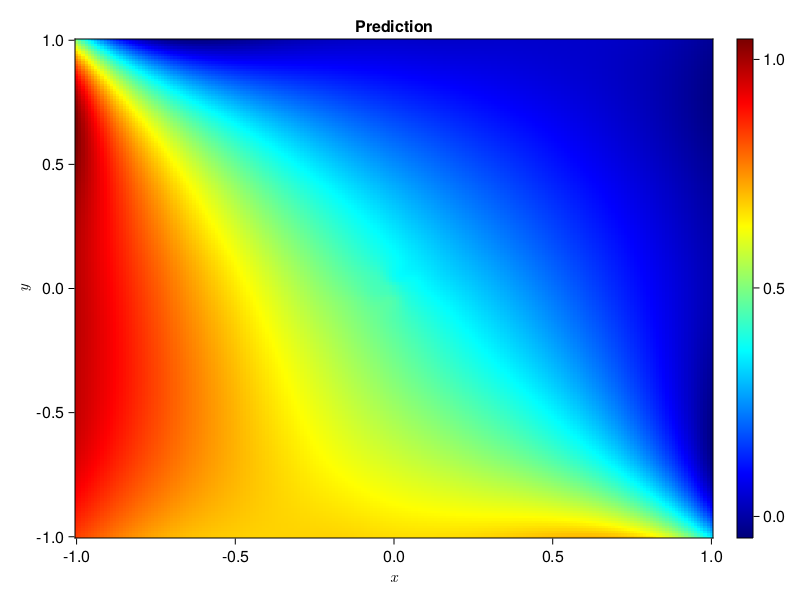

In [11]:
using CairoMakie, MakiePublication

phi = pinn.phi
xs, ys = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"x", ylabel=L"y", title="Prediction")
u_pred = [sum(pinn.phi([x, y], res.u)) for x in xs, y in ys]
fig, ax, hm = heatmap(xs, ys, u_pred, axis=axis, colormap=:jet)
Colorbar(fig[1,2], hm)
fig